### Definition
The method inspired from Goldenshluger-Lepski, this method try to balance between the Overfitting and Underfitting and try to not make the KDE too saw and too smooth, there are some intermediate terms need to be defined:
- $\hat{f}_{h,\eta} = K_\eta * \hat{f}_h(x) = \frac{1}{N} \sum_{i=1}^N K_\eta * K_h(x)$
- $K_h(x) = \frac{K(x / h)}{h}$, the $*$ operator is convolution

### References
- https://www.sciencedirect.com/science/article/pii/S0304414916300370
- https://rdrr.io/github/hericks/KDE/src/R/goldenshluger_lepski.R
- https://www.cirm-math.fr/ProgWeebly/Renc1615/Lacour.pdf
- https://people.eecs.berkeley.edu/~jiantao/ee290/scribe/lecture1819/lec18.pdf
- https://spartacus-idh.com/liseuse/030/#page/68

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
from tqdm import tqdm
from typing import Callable


In [3]:
def integrate(fn, lower, upper, subdivisions = 1000):
    intlen = upper - lower
    points = np.linspace(lower, upper, subdivisions)
    points = fn(points)
    return points.sum() * intlen / subdivisions

In [4]:
def load_kernel(type: str):
    if type == "rect":
        return lambda u: 1/2 * (np.abs(u) <= 1)
    elif type == "tri":
        return lambda u: (1 - np.abs(u)) * (np.abs(u) <= 1)
    elif type == "par":
        return lambda u: 3/4 * (1 - u**2) * (np.abs(u) <= 1)
    elif type == "bit":
        return lambda u: 15/16 * (1 - u**2)**2 * (np.abs(u) <= 1)
    elif type == "gauss":
        return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-u**2 / 2)
    elif type == "silv":
        return lambda u: 1/2 * np.exp(-np.abs(u) / np.sqrt(2)) * np.sin(np.abs(u) / np.sqrt(2) + np.pi/4)
    return None

In [150]:
def discrete_convolution(f, g):
    """
    Perform discrete convolution of two 1D arrays using numpy.
    
    Args:
        f (ndarray): Input signal.
        g (ndarray): Impulse response.
    
    Returns:
        ndarray: Convolution result.
    """
    # Get lengths of input signal and impulse response
    M = len(f)
    N = len(g)
    
    # Length of the output signal after convolution
    L = M + N - 1
    
    # Pad input signal and impulse response with zeros to ensure they are of equal length
    f_padded = np.pad(f, (0, L - M), mode='constant')
    g_padded = np.pad(g, (0, L - N), mode='constant')
    
    # Perform convolution using FFT
    F = np.fft.fft(f_padded)
    G = np.fft.fft(g_padded)
    Y = F * G
    y = np.fft.ifft(Y).real
    return y

In [217]:
def compute_K_h(K, h, x):
    return K(x / h) / h

In [329]:
def load_conv_kernel(K, h1, h2, N = 100_000):
    X = np.linspace(-100, 100, N)
    s = (max(X) - min(X)) / N
    t1 = compute_K_h(K, h1, X)
    t2 = compute_K_h(K, h2, X)
    out = s * discrete_convolution(t1, t2)
    # space = np.linspace(min(X), max(X), 2 * N - 1)
    space = np.linspace(2 * min(X) + s, 2 * max(X) - s, 2 * N - 1)
    return interp1d(space, out, bounds_error=False, fill_value=0)

In [187]:
def compute_f_h(K, h, X: np.array, x: float):
    return np.mean(compute_K_h(K, h, x - X))

In [186]:
def compute_f_h_eta(K, X, x):
    return np.mean(K(x - X))

0.410264018608512


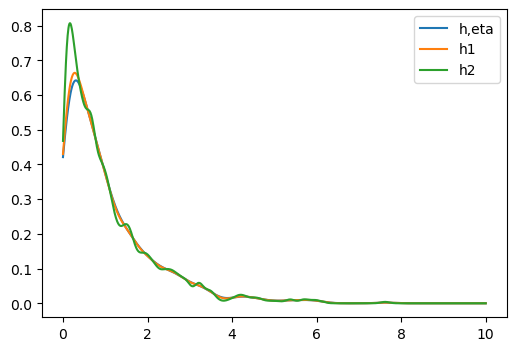

In [248]:
h1 = 0.1
h2 = 0.1
X = stats.expon.rvs(size=1000)
Z = np.linspace(0, 10, 1000)
K = load_kernel("gauss")
K_h_eta_1 = load_conv_kernel(K, h1, h2)

out_f_h_eta_1 = []
out_f_h_1 = []
out_f_h_2 = []

for z in Z:
    out_f_h_eta_1.append(compute_f_h_eta(K_h_eta_1, X, z))
    out_f_h_1.append(compute_f_h(K, h1, X, z))
    out_f_h_2.append(compute_f_h(K, h2, X, z))
plt.figure(figsize=(6, 4))
plt.plot(Z, out_f_h_eta_1, label="h,eta")
plt.plot(Z, out_f_h_1, label="h1")
plt.plot(Z, out_f_h_2, label="h2")
plt.legend()

In [252]:
h1 = 0.01
for h2 in np.linspace(h1, 1, 10):
    K_h_eta_1 = load_conv_kernel(K, h1, h2)
    K_eta = lambda u: compute_K_h(K, h2, u)
    l2_norm = integrate(lambda u: (K_h_eta_1(u) - K_eta(u))**2, min(X), max(X), 10000)
    print(l2_norm)

0.9900430718549571
1.0633845256014949e-05
4.171402735405489e-07
5.980357309097541e-08
1.4963985378724544e-08
5.128202565002755e-09
2.157634150643926e-09
1.051403726958738e-09
5.732197994717292e-10
3.4194027581153914e-10


In [279]:
def compute_V_h(K, h, N):
    l1_norm = integrate(K, lower=-100, upper=100, subdivisions=100000)**2
    l2_norm = integrate(lambda u: K(u)**2, lower=-100, upper=100, subdivisions=100000)
    return l1_norm * l2_norm / (h * N)

In [224]:
def iqr(data):
  # Sắp xếp data theo thứ tự tăng dần
  data.sort()

  # Tìm vị trí của tứ phân vị thứ nhất (Q1) và tứ phân vị thứ ba (Q3)
  n = len(data)
  q1_index = int(n * 0.25)
  q3_index = int(n * 0.75)

  # Tính Q1 và Q3
  q1 = data[q1_index]
  q3 = data[q3_index]

  # Tính IQR
  iqr = q3 - q1

  return iqr

def stddev(data):
  # Tính trung bình cộng
  mean = sum(data) / len(data)

  # Tính tổng bình phương sai lệch
  variance = sum([(x - mean)**2 for x in data]) / (len(data)-1)

  # Tính độ lệch chuẩn
  stddev = variance**0.5

  return stddev


def rules_of_thumb_h(data):
  # Tính độ lệch chuẩn và IQR của data
    std = stddev(data)
    IQR = iqr(data)
    return 0.9 * min(std, (IQR)/1.34) * len(data)**(-1/5)

In [298]:
def goldenshluger_lepski(K, H, X, kappa = 1.2):
    memory = {}
    N = len(X)
    pens = []
    for h in tqdm(H):
        V_h = compute_V_h(K, h, N)
        sup = -99999
        for eta in H:
            key = (min(h, eta), max(h, eta))
            if key in memory:
                K_h_eta = memory[key]
            else:
                K_h_eta = load_conv_kernel(K, h, eta)
                memory[key] = K_h_eta
                
            V_eta = compute_V_h(K, eta, N)
            l2_norm = 0
            for x in X:
                l2_norm += (compute_f_h_eta(K_h_eta, X, x) - compute_f_h(K, eta, X, x))**2
            l2_norm = l2_norm / N
            sup = max(sup, l2_norm - kappa * V_eta)
        pens.append(sup + 2*kappa*V_h)
    return H[np.argmin(pens)], pens

In [290]:
h = 1
X = stats.norm.rvs(size=1000)
H = np.linspace(0.001, 1, 30)
N = len(X)
sup = -999999
V_h = compute_V_h(K, h, N)
for eta in tqdm(H):
    K_h_eta = load_conv_kernel(K, h, eta)
    V_eta = compute_V_h(K, eta, N)
    l2_norm = 0
    for x in X:
        l2_norm += (compute_f_h_eta(K_h_eta, X, x) - compute_f_h(K, eta, X, x))**2
    l2_norm = l2_norm / N
    sup = max(sup, l2_norm - 1.2 * V_eta)
print(sup + 2 * 1.2 * V_h)

100%|██████████| 30/30 [00:08<00:00,  3.37it/s]

0.0062825119881102925


### Normal

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Rules of thumb:  0.22396224455511676
Lepski's bandwidth:  0.5375093869322802
MSE Lepski: 0.31877497220836265
MSE RoT: 0.07312874266363892


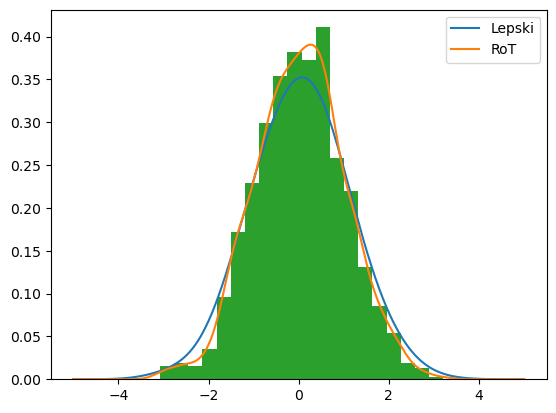

In [327]:
distribution = stats.norm
K = load_kernel("gauss")
X = distribution.rvs(size=1000)
# X = stats.norm.rvs(size=1000)
rot_h = rules_of_thumb_h(X)
optimal_h, pens = goldenshluger_lepski(K, np.linspace(0.3*rot_h, 3*rot_h, 10), X)


print("Rules of thumb: ", rot_h)
print("Lepski's bandwidth: ", optimal_h)

Z = np.linspace(-5, 5, 1000)
out = []
rot = []
true = []
for z in Z:
    out.append(compute_f_h(K, optimal_h, X, z))
    rot.append(compute_f_h(K, rot_h, X, z))
    true.append(distribution.pdf(z))

plt.plot(Z, out, label="Lepski")
plt.plot(Z, rot, label="RoT")
plt.hist(X, bins=20, density=True)
plt.legend()
print(f"MSE Lepski: {sum((np.array(out) - np.array(true))**2)}")
print(f"MSE RoT: {sum((np.array(rot) - np.array(true))**2)}")

### Exponential

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Rules of thumb:  0.1761930737314832
Lepski's bandwidth:  0.1585737663583349
MSE Lepski: 6.854160394645272
MSE RoT: 7.457737548140188


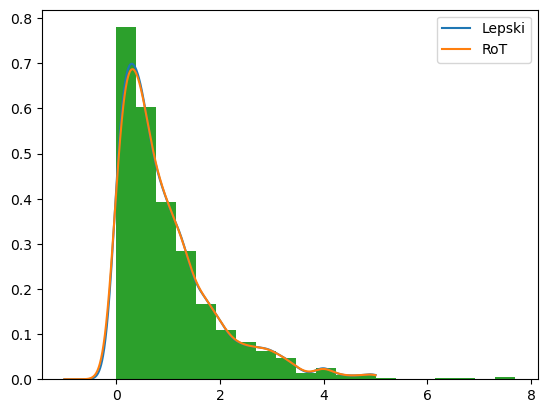

In [333]:
distribution = stats.expon
K = load_kernel("gauss")
X = distribution.rvs(size=1000)
# X = stats.norm.rvs(size=1000)
rot_h = rules_of_thumb_h(X)
optimal_h, pens = goldenshluger_lepski(K, np.linspace(0.3*rot_h, 3*rot_h, 10), X)


print("Rules of thumb: ", rot_h)
print("Lepski's bandwidth: ", optimal_h)

Z = np.linspace(-1, 5, 1000)
out = []
rot = []
true = []
for z in Z:
    out.append(compute_f_h(K, optimal_h, X, z))
    rot.append(compute_f_h(K, rot_h, X, z))
    true.append(distribution.pdf(z))

plt.plot(Z, out, label="Lepski")
plt.plot(Z, rot, label="RoT")
plt.hist(X, bins=20, density=True)
plt.legend()
print(f"MSE Lepski: {sum((np.array(out) - np.array(true))**2)}")
print(f"MSE RoT: {sum((np.array(rot) - np.array(true))**2)}")

### Cauchy

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

Rules of thumb:  0.3303727946997234
Lepski's bandwidth:  0.5946710304595021
MSE Lepski: 0.9591845298197843
MSE RoT: 0.2814929634896488


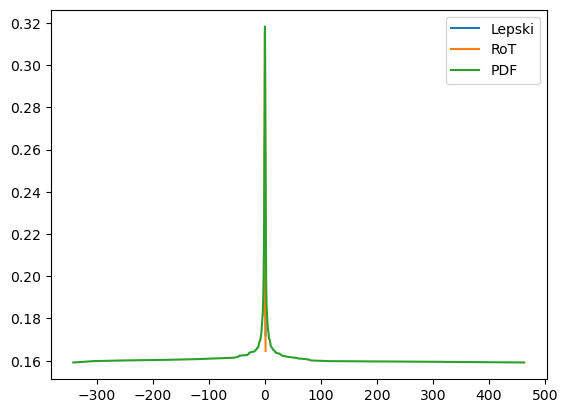

In [332]:
distribution = stats.cauchy
K = load_kernel("gauss")
X = distribution.rvs(size=1000)
# X = stats.norm.rvs(size=1000)
rot_h = rules_of_thumb_h(X)
optimal_h, pens = goldenshluger_lepski(K, np.linspace(0.3*rot_h, 3*rot_h, 10), X)

print("Rules of thumb: ", rot_h)
print("Lepski's bandwidth: ", optimal_h)

Z = np.linspace(-1, 1, 1000)
out = []
rot = []
true = []
for z in Z:
    out.append(compute_f_h(K, optimal_h, X, z))
    rot.append(compute_f_h(K, rot_h, X, z))
    true.append(distribution.pdf(z))

plt.plot(Z, out, label="Lepski")
plt.plot(Z, rot, label="RoT")
plt.plot(X, true, label="PDF")
plt.legend()
print(f"MSE Lepski: {sum((np.array(out) - np.array(true))**2)}")
print(f"MSE RoT: {sum((np.array(rot) - np.array(true))**2)}")